## GAN 첫걸음 도서 예제 사용

# Ch.6

## 일반적인 GAN 훈련방법  
### 1단계: 판별기를 실제 데이터로 훈련시킨다.
### 2단계: 판별기를 생성된 데이터로 훈련시킨다.
### 3단계: 생성기를 훈련시킨다

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 실제 데이터 소스 생성

In [3]:
# 실제 데이터에 대해 1010 패턴을 반환하는 함수 생성

def generate_real():
    real_data = torch.FloatTensor([1,0,1,0])
    return real_data

In [4]:
generate_real()

tensor([1., 0., 1., 0.])

In [5]:
# 데이터는 딱 떨어지는 값의 경우가 거의 없기에 약간 임의성 추가하기 위해 랜덤값을 가지도록 확인
# 순서대로 0.8~1.0 사이의 값과 0.0~0.2 사이의 값 반환
def generate_real():
    real_data= torch.FloatTensor(
        [np.random.uniform(0.8,1.0),
         np.random.uniform(0.0,0.2),
         np.random.uniform(0.8,1.2),
         np.random.uniform(0.0,0.2)])
    return real_data

In [6]:
generate_real()

tensor([0.8881, 0.1956, 0.9100, 0.0184])

### 판별기 만들기

출처: https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20sgd#torch.optim.SGD  
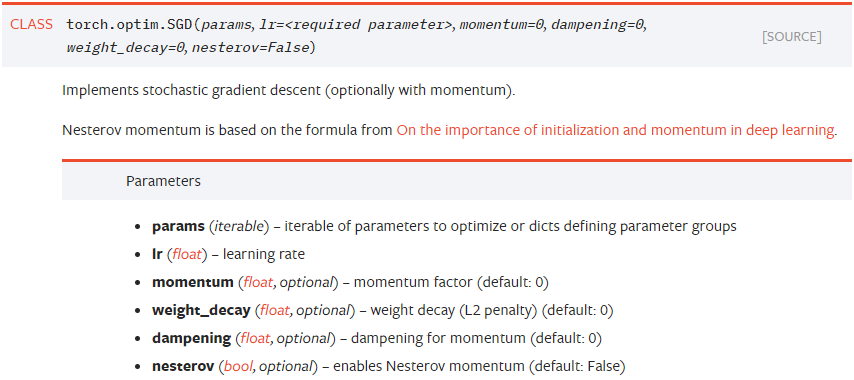

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 
        super().__init__()
        
        # 신경망 레이어
        self.model = nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid())
        
        # 손실함수 설정 _ Mean Squre Error 사용
        self.loss_function = nn.MSELoss()
        
        # Optimiser 설정 = SDG 사용 = 확률적 경사 하강법
        self.optimiser= torch.optim.SGD(self.parameters(), lr = 0.01)
        
        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    # 훈련 함수 정의
    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)
        
        # 손실계산
        loss = self.loss_function(outputs, targets)
        
        # 카운터 증가 시키고 10회마다 오차 저장
        self.counter +=1
        if (self.counter%10 == 0):   # 10으로 나눠서 0이면 10의 배수임.
            self.progress.append(loss.item())
            pass
        if (self.counter%10000 == 0):
            print("counter = ", self.counter)
            pass
        
    # 기울기 전파가 끝났다면 초기화하고 역전파 후 가중치를 갱신해야 함
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    
        pass
    
    # 훈련결과 차트로 그림 그려주기
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim = (0,1.0), figsize = (16,8), alpha = 0.1, marker = 'o', grid = True, yticks = (0, 0.25, 0.5))
        pass

In [8]:
Discriminator()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (loss_function): MSELoss()
)

### 판별기 테스트 하기

In [9]:
# 우선 노이즈 데이터를 입력하여 0으로 잘 판별하는지 확인하기
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [10]:
generate_random

<function __main__.generate_random(size)>

In [11]:
generate_random(4) #4개의 랜덤 숫자 꺼내옴

tensor([0.6415, 0.5973, 0.4049, 0.4374])

In [12]:
# 훈련 반복문 생성

D=Discriminator()

for i in range(10000):
    # 실제 데이터
    D.train(generate_real(), torch.FloatTensor([1.0]))
#     print(D.train)
    # 생성 데이터
    D.train(generate_random(4), torch.FloatTensor([0,0]))
#     print(D.train)
    pass

c:\users\yuuni\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


counter =  10000
counter =  20000


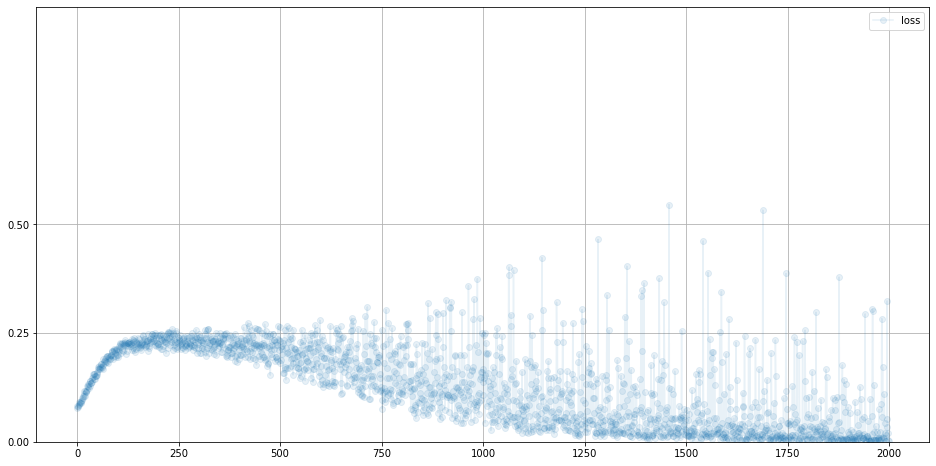

In [13]:
D.plot_progress()

In [14]:
# 임의의 패턴
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.8333914279937744
0.07167685031890869


#### Test 무시 할 것.

In [ ]:
def generate_random(size):
    test = torch.FloatTensor([1.0,0.0,1.0,0.0])
    return test

In [ ]:
D=Discriminator()

for i in range(10000):
    # 실제 데이터
    D.train(generate_real(), torch.FloatTensor([1.0]))
#     print(D.train)
    # 생성 데이터
    D.train(generate_random(4), torch.FloatTensor([0,0]))
#     print(D.train)
    pass

In [ ]:
D.plot_progress()

In [ ]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

#### ===================================================================================================

### 생성기 만들기

생성기는 판별자와 같이 단순한 함수로 이루어진것이 아닌 생성 및 이에 대한 피드백을 기준으로 훈련을 필요로 하는 신경망이며, 현 예제의 경우 [1,0,1,0]에 대해 생성이 이루어져야 하기에 마지막 출력 레이어의 경우 실제 데이터의 형식과 같이 네개의 출력이 필요하고 이에 대해 네개의 노드가 필요하다.

In [15]:
class Generator(nn.Module):
    
    def __init__(self):
        # 
        super().__init__()
        
        # 신경망 레이어
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid())
        
        # Optimiser 설정 = SDG 사용 = 확률적 경사 하강법
        self.optimiser= torch.optim.SGD(self.parameters(), lr = 0.01)
        
        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    # 훈련 함수 정의 = generator는 정답이 없기에 판별기에서 계산된 역전파를 가져다 사용하여야 하기 떄문에
    # 생성기에서 만든것을 판별기에 보내서 오차 계산을 하여 손실을 역전파시키어 생성기에서의 가중치를 업데이트 함.
    # 다만, 이때 오차는 판별기 엄데이트 되지 않는다.
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_outputs = self.forward(inputs)
        
        # 판별기로 전달
        d_ouputs = D.forward(g_outputs)
                
        # 오차계산
        loss = D.loss_function(d_ouputs, targets)
                
        # 카운터 증가 시키고 10회마다 오차 저장
        self.counter +=1
        if (self.counter%10 == 0):   # 10으로 나눠서 0이면 10의 배수임.
            self.progress.append(loss.item())
            pass
                
    # 기울기 전파가 끝났다면 초기화하고 역전파 후 가중치를 갱신해야 함
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    
        pass
    
    # 훈련결과 차트로 그림 그려주기
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim = (0,1.0), figsize = (16,8), alpha = 0.1, marker = 'o', grid = True, yticks = (0, 0.25, 0.5))
        pass

In [16]:
Generator()

Generator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): Sigmoid()
  )
)

#### 생성기 결과 확인

In [17]:
G = Generator()
G.forward(torch.FloatTensor([0.5])) # 0.5 단일값을 받아서 4개의 출력 생성

tensor([0.5227, 0.4545, 0.4018, 0.5269], grad_fn=<SigmoidBackward>)

## GAN 훈련하기

In [18]:
%%time

# Discriminator and Generator 생성
D = Discriminator()
G = Generator()

# Discriminator and Generator 훈련
for i in range(10000):
    
    # 1단계; 실제 데이터에 대해 판별기 훈련 (참에 대한 훈련)
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 2단계: 거짓에 대한 (생성기에서 비롯된 패턴을 이용) 판별기 훈련
    # G의 기울기는 사용하지 않기에 detach() 함수를 이용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 3단계: 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    pass

counter =  10000
counter =  20000
Wall time: 11.5 s


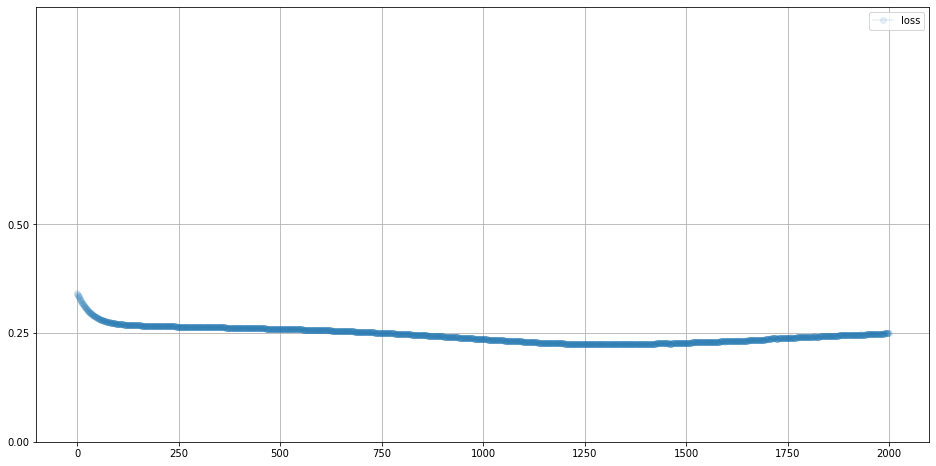

In [19]:
D.plot_progress()

In [20]:
torch.FloatTensor([0.5])

tensor([0.5000])

In [21]:
torch.FloatTensor([1.0])

tensor([1.])

In [22]:
D

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (loss_function): MSELoss()
)

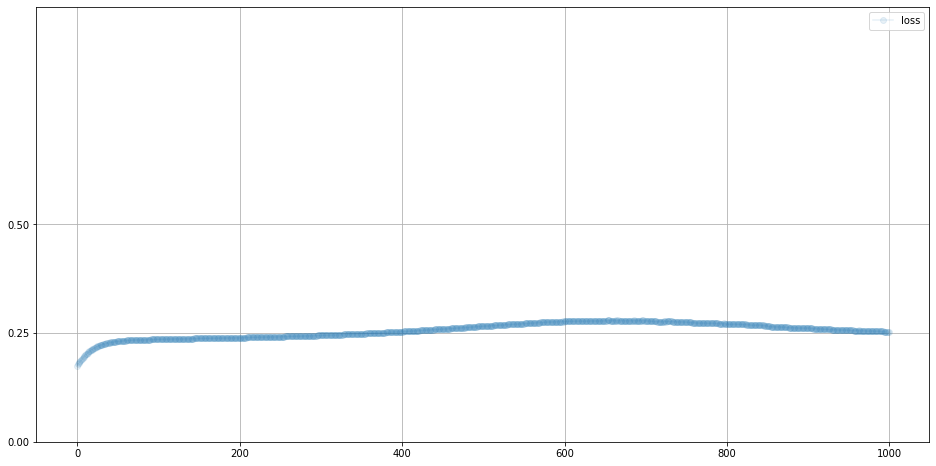

In [23]:
G.plot_progress()

훈련을 거친 생성기는 아래와 같이 1,0,1,0과 유사하게 데이터를 생산한다.

In [24]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.8622, 0.0755, 0.8782, 0.0909], grad_fn=<SigmoidBackward>)

In [29]:
# 1010패턴 훈련을 시각화 하여 확인
# 매 1000회의 이미지를 저장

if (i%1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().np())

In [30]:
plt.figure(figsize = (16,8))
plt.imshow(np.array(image_list).T, interpolation = 'none', cmp = 'Blues')

NameError: name 'image_list' is not defined

<Figure size 1152x576 with 0 Axes>